In [53]:
import pandas as pd, seaborn as sns, numpy as np, datetime, logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[ logging.FileHandler("../logs/fraud_notebook.log"), logging.StreamHandler()])
input_train = pd.read_csv('../data/fraud/05_model_input/x_train_transformed.csv')
output_train = pd.read_csv('../data/fraud/05_model_input/y_train_transformed.csv')
input_test = pd.read_csv('../data/fraud/05_model_input/x_test_transformed.csv')

data = pd.concat([input_train, output_train['fraud_flag']], axis=1)
target = pd.get_dummies(data['fraud_flag'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0, shuffle=True, stratify=target)
logging.info(f'input_train={len(input_train.index)},output_train={len(output_train.index)},data={len(data.index)},target={len(target.index)},x_train={len(x_train.index)},'+\
      f'x_test={len(x_test.index)},y_train={len(y_train.index)},y_test={len(y_test.index)}')
x_train = x_train.drop(['fraud_flag'], axis=1)
x_test = x_test.drop(['fraud_flag'], axis=1)
# logging.info(f'y_test={y_test.head()}')
# logging.info(f'x_test={x_test.head()}')
# logging.info(f'output_train={output_train.head()}')
y_test['ID'] = x_test['ID']
y_test['fraud_flag'] = y_test[1.0]
# logging.info(f'y_test={y_test.head()}')

2023-04-04 16:55:27,213 [INFO] input_train=62169,output_train=62169,data=62169,target=62169,x_train=49735,x_test=12434,y_train=49735,y_test=12434


In [54]:
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

In [55]:
import seaborn as sns, keras
import matplotlib.pyplot as plt
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        metrics(str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("RMSE")

In [56]:
def score(y_true, y_pred_proba):
    import numpy as np
    from sklearn.metrics import average_precision_score
    ''' 
    Return the area under the Precision-Recall curve.  
    Args:
        - y_true (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the ground truth observations (second column).
        - y_pred_proba (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the predicted probabilities estimates for the minority class (second column).
    Returns:
        float
    '''   
    y_true_sorted = y_true.sort_values(by='ID').reset_index(drop=True)[['ID', 'fraud_flag']]
    y_pred_proba_sorted = y_pred_proba.sort_values(by='ID').reset_index(drop=True)[['ID', 'fraud_flag']]

    score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), np.ravel(y_pred_proba_sorted.iloc[:, 1]))
    return score

In [57]:
def build_model(activations=['relu', 'relu', 'sigmoid'], batch_size=10, epochs=100, optimizer='adam', loss='binary_crossentropy', units=256):
    layers = [keras.layers.Dense(units, activation=activations[0], input_shape=(x_train.shape[1],))]
    for activation in activations[1:len(activations)-1]:
        layers.append(keras.layers.Dense(units, activation=activation))
    layers.append(keras.layers.Dense(2, activation=activations[-1]))
    model = keras.Sequential(layers)
    metrics = [
            keras.metrics.FalseNegatives(name="fn"),
            keras.metrics.FalsePositives(name="fp"),
            keras.metrics.TrueNegatives(name="tn"),
            keras.metrics.TruePositives(name="tp"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ]
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)
    y_columns = [0.0, 1.0]
    # y_columns = ['fraud_flag']
    # y_columns = [1.0]
    history = model.fit(x_train, y_train[y_columns], validation_data=(x_test, y_test[y_columns]), batch_size = batch_size, epochs = epochs, verbose=0)
    plot_history(history, 'val_loss')
    return model
def predict(estimator, x):
    y_predict = pd.DataFrame(x['ID'].copy(), columns=['ID'])
    prediction = estimator.predict(x)
    # logging.info(f'{type(prediction)},prediction={prediction[:10]}')
    prediction = estimator.predict(x)
    y_predict['fraud_flag'] = [p[1] for p in prediction]
    # logging.info(f'prediction={prediction[:10]}')
    y_predict = y_predict.reset_index(drop=True)
    return y_predict
def evaluate(model):
    y_predict = predict(model, x_test)
    current_score = score(y_test[['ID', 'fraud_flag']], y_predict)
    print(f'current_score={current_score}')
    return y_predict, current_score
def calibrate_model(activation_groups, batch_size = 10, epochs = 100, optimizers=['adam'], losses=['binary_crossentropy'], units=256):
    best_score = 0
    best_model = None
    best_activation = None
    best_loss = None
    best_optimizer = None
    for activations in activation_groups:
        name = '_'.join(activations)
        for optimizer in optimizers:
            for loss in losses:
                start_time = datetime.datetime.now()
                model = build_model(activations, batch_size, epochs, optimizer, loss, units)
                y_predict = predict(model, x_test)
                current_score = score(y_test[['ID', 'fraud_flag']], y_predict)    
                end_time = datetime.datetime.now()
                duration = (end_time - start_time)
                logging.info(f'{current_score} for {name}/{optimizer}/{loss}/{units} in {duration}')
                if current_score > best_score:
                    # print(f'y_predict={y_predict}')
                    best_score = current_score
                    best_activation = name
                    best_optimizer = optimizer
                    best_model = model
                    best_loss = loss
    logging.info(f'The winner is {best_activation}/{best_optimizer}/{best_loss} with a score of {best_score} !')
    return best_model, best_activation, best_score, best_optimizer

389/389 [==============================] - 0s 967us/step


2023-04-04 16:56:20,499 [INFO] 0.027079400442171823 for relu_relu_sigmoid/adam/binary_crossentropy/250 in 0:00:52.533577


389/389 [==============================] - 0s 1ms/step


2023-04-04 16:57:57,966 [INFO] 0.026790548606321022 for relu_relu_sigmoid/adam/kl_divergence/250 in 0:01:37.466925


389/389 [==============================] - 0s 1ms/step


2023-04-04 16:59:35,928 [INFO] 0.014479195946958998 for relu_sigmoid_sigmoid/adam/binary_crossentropy/250 in 0:01:37.961094


389/389 [==============================] - 1s 1ms/step


2023-04-04 17:01:12,600 [INFO] 0.01494149928364958 for relu_sigmoid_sigmoid/adam/kl_divergence/250 in 0:01:36.661045


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:02:53,361 [INFO] 0.014556860221972012 for relu_softmax_sigmoid/adam/binary_crossentropy/250 in 0:01:40.761414


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:04:32,213 [INFO] 0.014556860221972012 for relu_softmax_sigmoid/adam/kl_divergence/250 in 0:01:38.852190


389/389 [==============================] - 1s 1ms/step


2023-04-04 17:06:05,230 [INFO] 0.0449767789937771 for relu_softplus_sigmoid/adam/binary_crossentropy/250 in 0:01:33.015653


389/389 [==============================] - 1s 1ms/step


2023-04-04 17:07:40,150 [INFO] 0.02168581445437908 for relu_softplus_sigmoid/adam/kl_divergence/250 in 0:01:34.919189


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:09:25,939 [INFO] 0.014985506881036306 for relu_softsign_sigmoid/adam/binary_crossentropy/250 in 0:01:45.787393


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:11:08,175 [INFO] 0.019635042665597853 for relu_softsign_sigmoid/adam/kl_divergence/250 in 0:01:42.235348


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:12:46,321 [INFO] 0.014901424955127286 for relu_tanh_sigmoid/adam/binary_crossentropy/250 in 0:01:38.145217


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:14:20,512 [INFO] 0.014988015844356096 for relu_tanh_sigmoid/adam/kl_divergence/250 in 0:01:34.189759


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:15:53,961 [INFO] 0.0609493143918346 for relu_selu_sigmoid/adam/binary_crossentropy/250 in 0:01:33.448034


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:17:24,915 [INFO] 0.04251984429560679 for relu_selu_sigmoid/adam/kl_divergence/250 in 0:01:30.952429


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:18:50,968 [INFO] 0.057360836078976275 for relu_elu_sigmoid/adam/binary_crossentropy/250 in 0:01:26.051892


389/389 [==============================] - 0s 1ms/step


2023-04-04 17:20:19,102 [INFO] 0.03199404272666087 for relu_elu_sigmoid/adam/kl_divergence/250 in 0:01:28.132651


389/389 [==============================] - 1s 2ms/step


2023-04-04 17:23:06,603 [INFO] 0.034580311660200924 for relu_elu_elu_sigmoid/adam/binary_crossentropy/250 in 0:02:47.500543


389/389 [==============================] - 1s 1ms/step


2023-04-04 17:25:49,390 [INFO] 0.05899564470275766 for relu_elu_elu_sigmoid/adam/kl_divergence/250 in 0:02:42.785986


389/389 [==============================] - 1s 2ms/step


2023-04-04 17:29:20,117 [INFO] 0.05884181875983837 for relu_elu_elu_elu_sigmoid/adam/binary_crossentropy/250 in 0:03:30.725657


389/389 [==============================] - 1s 2ms/step


2023-04-04 17:32:48,483 [INFO] 0.051105352893597904 for relu_elu_elu_elu_sigmoid/adam/kl_divergence/250 in 0:03:28.365036


The winner is relu_selu_sigmoid/adam/binary_crossentropy with a score of 0.0609493143918346 !


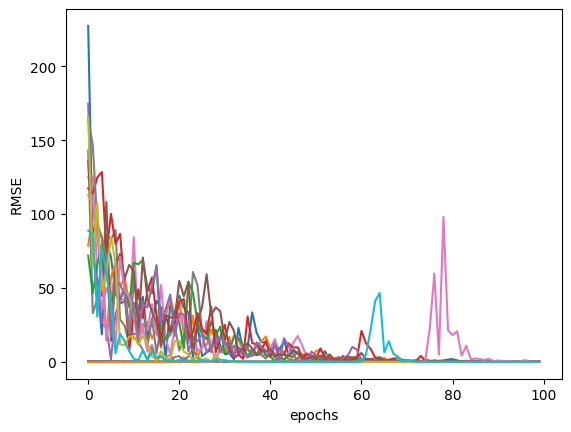

In [58]:
# activations = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu']
activation_groups = [ 
    ['relu', 'relu', 'sigmoid'],
    ['relu', 'sigmoid', 'sigmoid'],
    ['relu', 'softmax', 'sigmoid'],
    ['relu', 'softplus', 'sigmoid'],
    ['relu', 'softsign', 'sigmoid'],
    ['relu', 'tanh', 'sigmoid'],
    ['relu', 'selu', 'sigmoid'],
    ['relu', 'elu', 'sigmoid'],
    ['relu', 'elu', 'elu', 'sigmoid'],
    ['relu', 'elu', 'elu', 'elu', 'sigmoid'],
    ]
# losses = ['binary_crossentropy', 'sparse_categorical_crossentropy', 'poisson', 'kl_divergence']
losses = ['binary_crossentropy', 'kl_divergence']
# optimizers = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']
# optimizers = ['adam']
optimizers = ['adam']
best_model, best_activation, best_score, best_optimizer = calibrate_model(activation_groups, 1000, 100, optimizers, losses, 250)